In [219]:
import os
os.chdir("..")
from typing import Mapping,Iterable, Iterator, Tuple, TypeVar,Optional,Callable,Dict
from itertools import islice
from rl.distribution import Choose
from rl.distribution import Categorical
from rl.prediction_utils import fmrp_episodes_stream
from rl.markov_process import (MarkovRewardProcess,
                               FiniteMarkovRewardProcess, TransitionStep)
from rl.function_approx import learning_rate_schedule
from rl.returns import returns


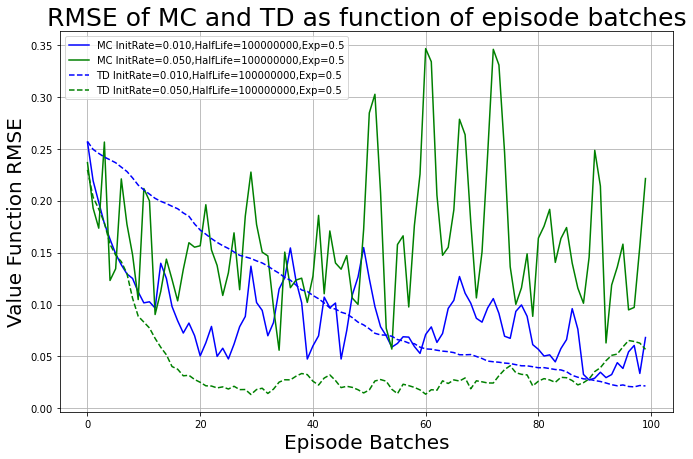

In [108]:
class RandomWalkMRP(FiniteMarkovRewardProcess[int]):
    '''
    This MRP's states are {0, 1, 2,...,self.barrier}
    with 0 and self.barrier as the terminal states.
    At each time step, we go from state i to state
    i+1 with probability self.p or to state i-1 with
    probability 1-self.p, for all 0 < i < self.barrier.
    The reward is 0 if we transition to a non-terminal
    state or to terminal state 0, and the reward is 1
    if we transition to terminal state self.barrier
    '''
    barrier: int
    p: float

    def __init__(
        self,
        barrier: int,
        p: float
    ):
        self.barrier = barrier
        self.p = p
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[int, Optional[Categorical[Tuple[int, float]]]]:
        d: Dict[int, Optional[Categorical[Tuple[int, float]]]] = {
            i: Categorical({
                (i + 1, 0. if i < self.barrier - 1 else 1.): self.p,
                (i - 1, 0.): 1 - self.p
            }) for i in range(1, self.barrier)
        }
        d[0] = None
        d[self.barrier] = None
        return d


if __name__ == '__main__':
    from rl.chapter10.prediction_utils import compare_td_and_mc

    this_barrier: int = 10
    this_p: float = 0.5
    random_walk: RandomWalkMRP = RandomWalkMRP(
        barrier=this_barrier,
        p=this_p
    )
    compare_td_and_mc(
        fmrp=random_walk,
        gamma=1.0,
        mc_episode_length_tol=1e-6,
        num_episodes=700,
        learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
        initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
        plot_batch=7,
        plot_start=0
    )

# p1 p2 p3

In [215]:
S = TypeVar('S')
A = TypeVar('A')

# Each-vist mc tabular for prediction
def mc_tabular(
        traces: Iterable[Iterable[TransitionStep[S]]],
        gamma: float,
        tolerance: float,
        count_to_weight_func:Callable[[float], float], 
        num_iter: int)-> Dict[S,float]:
    '''Evaluate an MRP using the all-visit monte carlo method, simulating episodes
    of the given number of steps.
    Each value this function yields represents the approximated value
    function for the MRP after one additional epsiode.
    Arguments:
      traces -- an iterator of simulation traces from an MRP
      gamma: float, related to the nature of mrp
      tolerance: float,  related to the nature of mrp
      count_to_weight func:Callable -- default 1/n, simple average over first n occurance of each state
      num_iter: num of calculus 
    Returns an iterator with updated value function
    '''
    value_function: Optional[Tuple[S,float]]={}
    count={}
    episodes = (returns(trace, gamma,tolerance) for trace in traces)   
    episodes=[list(episode) for episode in islice(episodes,num_iter)]
    for episode in episodes:
        for step in episode:
            s,g=step.state,step.return_
            if s not in value_function:
                value_function[s]=step.return_
                count[s]=1
            else:
                count[s]=count[s]+1
                value_function[s]=value_function[s]+count_to_weight_func(count[s])*(g-value_function[s])
    return value_function


    
    


## value_function after 10000 episodes in MC

In [201]:
mc_tabular(fmrp_episodes_stream(random_walk),gamma=1,tolerance=1e-6,count_to_weight_func=lambda n:1/n,num_iter=10000)

{4: 0.40160781598584483,
 3: 0.3023439211391015,
 2: 0.20855858419165693,
 1: 0.1056565656565658,
 8: 0.8084724868317814,
 9: 0.9047713520484046,
 7: 0.7067133229652655,
 6: 0.6058230256898187,
 5: 0.5069495245062186}

## value_function after 100000 episodes in MC

In [202]:
mc_tabular(fmrp_episodes_stream(random_walk),gamma=1,tolerance=1e-6,count_to_weight_func=lambda n:1/n,num_iter=100000)

{5: 0.5021434944399756,
 6: 0.6041248925809349,
 7: 0.7046090912599171,
 8: 0.8037061726596947,
 9: 0.9031333074464654,
 4: 0.4012591307765274,
 3: 0.3021918870037043,
 2: 0.20233322620114966,
 1: 0.10129463793259066}

In [270]:
# td tabular for prediction
def td_tabular(
    alpha: float,
    fmrp: FiniteMarkovRewardProcess[S],
    gamma: float,
    num_step: int
)-> Dict[S,float]:
    
    value_function: Optional[Tuple[S,float]]={}
    for _ in range(num_step):
        sample=next(random_walk.simulate_reward(Choose(set(random_walk.non_terminal_states))))
        state, nxt_state, reward=sample.state,sample.next_state,sample.reward
        if state not in value_function:
            value_function[state]=0
        if nxt_state not in value_function:
            if not fmrp.is_terminal(nxt_state):
                value_function[nxt_state]=0
        
        if not fmrp.is_terminal(nxt_state):
            value_function[state]=value_function[state]+alpha*(reward+gamma*value_function[nxt_state]-value_function[state])
        else:
            value_function[state]=value_function[state]+alpha*(reward-value_function[state])
    return value_function

## value_function after 100000 time steps in TD

In [271]:
td_tabular(
    alpha=0.01,
    fmrp=random_walk,
    gamma=1,
    num_step=100000)

{2: 0.19559042895864817,
 3: 0.29347165490441274,
 1: 0.08899394589402099,
 8: 0.7986253727227699,
 9: 0.8952947250679569,
 5: 0.47002828153428994,
 6: 0.5649499111073701,
 4: 0.3913760932163493,
 7: 0.6873575651982602}

## value_function after 1000000 time steps in TD

In [272]:
td_tabular(
    alpha=0.01,
    fmrp=random_walk,
    gamma=1,
    num_step=1000000)

{7: 0.6897591741323753,
 8: 0.7923744201477011,
 2: 0.18706092842143102,
 3: 0.28580989437933896,
 9: 0.8934437414159422,
 5: 0.4998417742383144,
 4: 0.39462947184566105,
 1: 0.09422021615744788,
 6: 0.5873929960755873}

# The performances of TD Tabular and MC Tabular are perfect as expected

# p4
ignored